   OBJECTID  Shape_Leng  Shape_Area                     zone  LocationID  \
0         1    0.116357    0.000782           Newark Airport           1   
1         2    0.433470    0.004866              Jamaica Bay           2   
2         3    0.084341    0.000314  Allerton/Pelham Gardens           3   
3         4    0.043567    0.000112            Alphabet City           4   
4         5    0.092146    0.000498            Arden Heights           5   

         borough                                           geometry  
0            EWR  POLYGON ((933100.918 192536.086, 933091.011 19...  
1         Queens  MULTIPOLYGON (((1033269.244 172126.008, 103343...  
2          Bronx  POLYGON ((1026308.770 256767.698, 1026495.593 ...  
3      Manhattan  POLYGON ((992073.467 203714.076, 992068.667 20...  
4  Staten Island  POLYGON ((935843.310 144283.336, 936046.565 14...  


<Axes: >

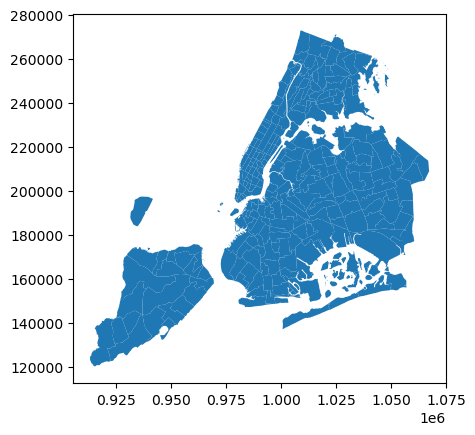

In [33]:
import geopandas as gpd
import scipy.io as scipy
import os
import os.path as osp
import pandas as pd
import numpy as np
import pickle
import networkx as nx
from tqdm import tqdm

# 读取Shapefile
gdf = gpd.read_file("taxi_zones/taxi_zones.shp")

# 查看数据
print(gdf.head())

# 查看地图
gdf.plot()

In [23]:
gdf.loc[0]

OBJECTID                                                      1
Shape_Leng                                             0.116357
Shape_Area                                             0.000782
zone                                             Newark Airport
LocationID                                                    1
borough                                                     EWR
geometry      POLYGON ((933100.9183527103 192536.08569720192...
Name: 0, dtype: object

In [30]:
import geopandas as gpd
from shapely.geometry import Point

def find_borough(longitude,latitude):
    # 假设有一个点的WGS 84经纬度坐标
    point = Point(longitude,latitude)  # 经度和纬度
    point_gdf = gpd.GeoDataFrame([1], geometry=[point], crs="EPSG:4326")  # 创建GeoDataFrame并指定原始CRS

    # 转换点的CRS到EPSG:2263
    point_gdf = point_gdf.to_crs(epsg=2263)

    # 检查是否存在于某个区域
    point_in_poly = gdf[gdf.geometry.contains(point_gdf.geometry.iloc[0])]
    if not point_in_poly.empty:
        return point_in_poly.index[0], point_in_poly['borough'].values[0], point_in_poly['zone'].values[0]
    else:
        print("Not Found")

In [31]:
find_borough(-73.985, 40.758)  # Manhattan

(229, 'Manhattan', 'Times Sq/Theatre District')

In [55]:
BASEDIR = '/Users/xwan0069/Desktop/Projects/RL_Simulator/NYC'
MAP_NAME = 'NYC_Manhattan_Map.mat'
REQ_NAME = 'Requests.mat'
OUTPUT_NAME = 'Manhattan_Map' 
map = scipy.loadmat(osp.join(BASEDIR,MAP_NAME))
map_Arcs = pd.DataFrame(map['Arcs']) #ArcsID, Node_Origin, Node_destination, starts from 1 
map_CityArcs = pd.DataFrame(map['CityArcs']) #NodeID, NodeID, starting from 1, 1 means connected.
map_EdgeTimes = pd.DataFrame(map['EdgeTimes']) #ArcTime in seconds, position is ArcID
map_Nodes = pd.DataFrame(map['Nodes']) # Node ID, latitude, longtitude
map_dijkstra_A = pd.DataFrame(map['dijkstra_A']) #Unclear
map_dijkstra_V = pd.DataFrame(map['dijkstra_V']).T #shortest time matrix, transpose it to align with others (Oid, Did)

# Make the index start from 1
map_CityArcs.index = map_CityArcs.index + 1
map_CityArcs.columns = map_CityArcs.columns + 1
map_dijkstra_V.index = map_dijkstra_V.index + 1
map_dijkstra_V.columns = map_dijkstra_V.columns + 1

map_Arcs.rename(columns={0:'ArcID',1:'Oid',2:'Did'},inplace=True)
map_EdgeTimes.rename(columns={0:'ArcTime'},inplace=True)
map_Nodes.rename(columns={0:'NodeID',1:'Latitude',2:'Longitude'},inplace=True)

map_Nodes['NodeID'] = map_Nodes['NodeID'].astype(int)

# Add self-Connection to map_CityArcs
for i in range(1, map_Nodes.shape[0]+1):
    map_CityArcs.loc[i,i] = 1

map_CityArcs.sum().sum()- 4091
with open(osp.join(BASEDIR,'NYC_Manhattan_CityArc.pickle'), 'wb') as f:
    pickle.dump(map_CityArcs, f)

map_EdgeTimes.insert(0, "ArcID", range(1, len(map_EdgeTimes) + 1))

map_Nodes.loc[map_Nodes['NodeID'] == 3019, 'Longitude'] = -73.950005
map_Nodes.loc[map_Nodes['NodeID'] == 2597, 'Longitude'] = -73.959878
map_Nodes.loc[map_Nodes['NodeID'] == 2597, 'Latitude'] = 40.757101

In [56]:
# Generate Graph
G = nx.DiGraph()
num_edges = len(map_Arcs) #num of edges in the map
arcs = tqdm(map_Arcs.iterrows(), total=num_edges, ncols=100, desc='Building network...') #ncols is the width of the progress bar

for idx, arcs in arcs:
    Oid = arcs['Oid']
    Did = arcs['Did']
    ArcID = arcs['ArcID']-1 #EdgeTime is indexed from 0
    G.add_node(Oid) #add current node to the graph
    G.add_node(Did) #add destination node to the graph
    G.add_edge(Oid, Did, TimeCost=map_EdgeTimes.iloc[ArcID]['ArcTime']) #add the arc to the graph

print('Network data loaded.')
print(f'Network has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.')

for i, node in enumerate(G.nodes()):
    G.nodes[node]['longitude'] = map_Nodes.loc[map_Nodes['NodeID'] == node]['Longitude'].values[0]
    G.nodes[node]['latitude'] = map_Nodes.loc[map_Nodes['NodeID'] == node]['Latitude'].values[0]


Building network...: 100%|███████████████████████████████████| 9452/9452 [00:00<00:00, 13500.24it/s]


Network data loaded.
Network has 4091 nodes and 9452 edges.


In [57]:
# Check node
invalid_nodes = []
for i, node in enumerate(G.nodes()):
    lat = G.nodes[node].get('latitude')
    lon = G.nodes[node].get('longitude')
    if lat is None or lon is None or np.isnan(lat) or np.isnan(lon):
        invalid_nodes.append(node)

print("Invalid nodes:", invalid_nodes)

Invalid nodes: []


In [62]:
# find borough for each node
for i, node in enumerate(G.nodes()):
    lat = float(G.nodes[node].get('latitude'))
    lon = float(G.nodes[node].get('longitude'))
    borough_id, borough, zone = find_borough(lon, lat)
    G.nodes[node]['borough'] = borough
    G.nodes[node]['zone'] = zone
    G.nodes[node]['borough_id'] = borough_id

# check node
G.nodes[1]

{'longitude': -74.017946,
 'latitude': 40.706991,
 'borough': 'Manhattan',
 'zone': 'Battery Park City',
 'borough_id': 12}

In [63]:
# save graph
pickle.dump(G, open(osp.join(BASEDIR, 'NYC_Manhattan_Graph.pickle'), 'wb'))